# Supervised Learning: Model Preparation - Data Cleaning 3 - Outliers

## Assignment: 

- Working with [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [16]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

First, we fill in missing values using interpolation:

In [17]:

fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = education_df["STATE"].unique()

for state in states:
    education_df.loc[education_df["STATE"] == state, fill_list] = education_df.loc[education_df["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
education_df.dropna(inplace=True)

In [33]:
education_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441
211,1996_ARIZONA,ARIZONA,1996,764681.0,4143304.0,378917.0,1798363.0,1966024.0,4391555.0,1860007.0,...,62793.0,60514.0,42041.0,511925.0,210289.0,726709.0,217.575940,267.874834,206.529788,263.283638
212,1996_ARKANSAS,ARKANSAS,1996,452907.0,2183384.0,192152.0,1296247.0,694985.0,2297381.0,1264275.0,...,33855.0,37064.0,27613.0,283883.0,131997.0,417860.0,215.846436,261.652745,208.837716,271.834590
213,1996_CALIFORNIA,CALIFORNIA,1996,5460484.0,31282981.0,2603882.0,17061474.0,11617625.0,31561692.0,16880730.0,...,435217.0,406456.0,298669.0,3516572.0,1525618.0,5115423.0,209.129083,262.772478,201.912591,269.197451
214,1996_COLORADO,COLORADO,1996,655679.0,3891203.0,194998.0,1664676.0,2031529.0,4075165.0,2052264.0,...,52524.0,52269.0,37179.0,423510.0,185700.0,621730.0,225.805858,275.608214,221.653243,268.168154


In [39]:
education_df.loc[education_df["STATE"] == "ARIZONA", ["ENROLL", "TOTAL_REVENUE"]].head()

,ENROLL,TOTAL_REVENUE
211,764681.0,4143304.0
418,814807.0,5479168.0
574,875111.0,6529894.0
678,919875.0,7550109.0
782,969875.0,8724434.0


In [47]:
education_df.loc[education_df.STATE == "ARIZONA", "ENROLL"].interpolate()

211     764681.0
418     814807.0
574     875111.0
678     919875.0
782     969875.0
889     981303.0
995     946571.0
1099    941726.0
1201    944978.0
1449    938274.0
Name: ENROLL, dtype: float64

In [46]:
education_df.iloc[1:10, 3]

211     764681.0
212     452907.0
213    5460484.0
214     655679.0
215     499815.0
217      79802.0
218    2175352.0
220     187104.0
224     502343.0
Name: ENROLL, dtype: float64

### 1. Consider the two variables: *TOTAL_REVENUE* and *TOTAL_EXPENDITURE*. Do these variables have outlier values?

Plotting the TOTAL_REVENUE and TOTAL_EXPENDITURE variables as boxplots: 

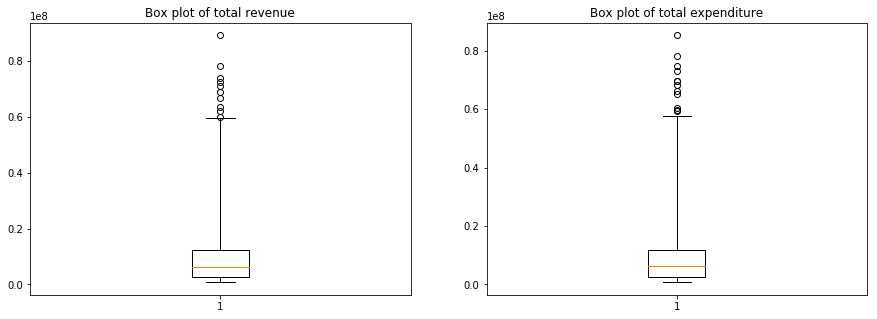

In [18]:

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 5)
plt.title("Box plot of total revenue")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Box plot of total expenditure")
plt.show()

The points above the whiskers in the boxplots indicate outliers in both variables, TOTAL_REVENUE and TOTAL_EXPENDITURE

### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

From the course material: 

One common way of limiting the outlier values is called **winsorization**. Winsorization can be applied in *one-way* or *two-way* techniques. In one-way winsorization, we either limit the lowest end of the value distribution or the highest end. In two-way winsorization, we set both the lowest end and the highest end. 

The idea in winsorization is to set the values of the extreme points to the value of a specified percentile. For example, we may set the values of the highest end of the distribution to the value of the $95^{th}$ percentile. Similary, we can set the values of the lowest end to the value of the $5^{th}$ percentile.

We can winsorize a variable using scipy's `winsorize()` method.

In [19]:
from scipy.stats.mstats import winsorize

# Winsorizing the values - limiting the distributions to the 95th percentile:

winsorized_revenue = winsorize(education_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_expenditure = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.05))

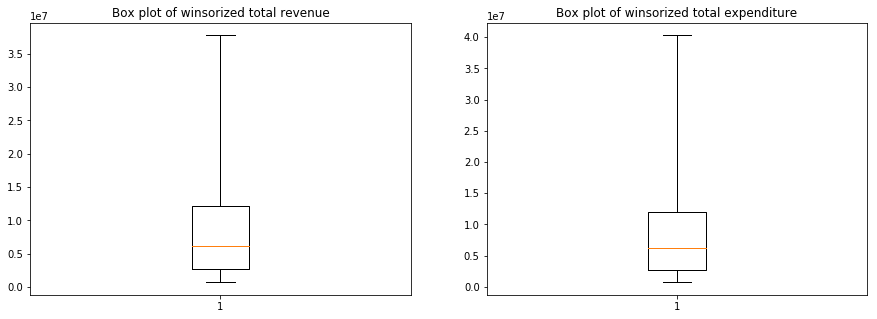

In [20]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 5)
plt.title("Box plot of winsorized total revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 5)
plt.title("Box plot of winsorized total expenditure")
plt.show()

Looks like the outliers above the upper whiskers are gone, now the values in the distribution are capped at the 95th percentile

### 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [21]:
# Creating budget_deficit:
budget_deficit = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE

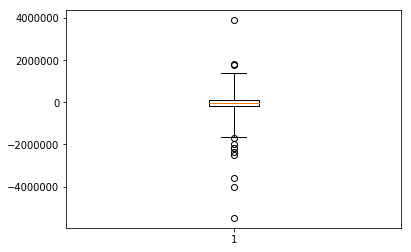

In [22]:
plt.boxplot(budget_deficit, whis = 5)
plt.show()

Looks like we have outliers above and below the quantiles. Time to winsorize to the 5th and 95th percentile:

In [23]:
winsorized_budget = winsorize(budget_deficit, (0.05, 0.05))

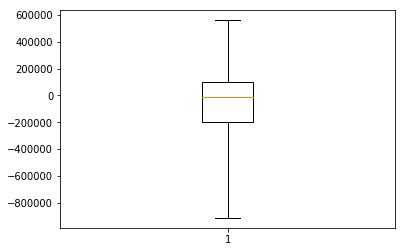

In [25]:
plt.boxplot(winsorized_budget, whis = 5)
plt.show()

### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. But this time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [26]:
budget_deficit2 = winsorized_revenue - winsorized_expenditure


Text(0.5, 1.0, 'Box plot of budget deficit 2')

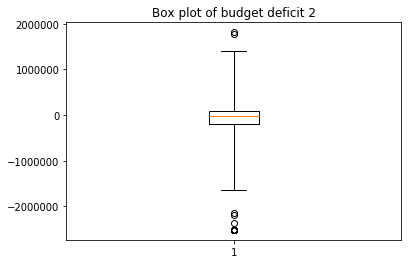

In [27]:
plt.boxplot(budget_deficit2, whis = 5)
plt.title("Box plot of budget deficit 2")


In [29]:
winsorized_budget2 = winsorize(budget_deficit2, (0.05, 0.05))


Text(0.5, 1.0, 'Box plot of budget deficit 2')

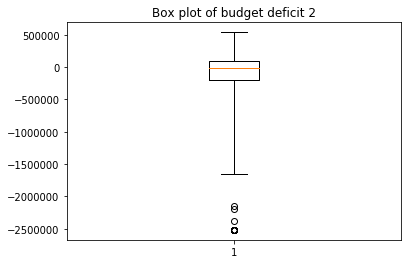

In [30]:
# Eliminataing the outliers with winsorization:

plt.boxplot(winsorized_budget2, whis = 5)
plt.title("Box plot of budget deficit 2")

The remaining outliers in can be eliminated with a increased lower bound for our winsorization function

### 5. Compare some basic statistics of the budget variables you end up with in the third and the fourth questions. Do you see any differences?

In [31]:
pd.DataFrame({"original_budget": budget_deficit, "winsorized_budget1": winsorized_budget,
              "winsorized_budget2": winsorized_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,4.660000e+02,466.000000,4.660000e+02
mean,-8.094882e+04,-58733.012876,-1.720532e+05
std,6.144222e+05,341300.816505,6.509561e+05
min,-5.487742e+06,-913765.000000,-2.518429e+06
25%,-1.965748e+05,-196574.750000,-2.047750e+05
50%,-8.872500e+03,-8872.500000,-1.282350e+04
75%,1.013948e+05,101394.750000,9.826300e+04
max,3.897129e+06,560511.000000,5.400550e+05


For almost all critical statistics, the two variables differ substantially. For example:

1. The mean of the first variant is -61210.33 whereas the mean of the second variant is -173636.

2. The median of the first variant is -12823.5 whereas the median of the second variant is -14600.5.

3. The maximum of the first variant is 560511 whereas the maximum of the second variant is 540055.

The differences imply that chosing the outlier elimination strategy is very critical as it substantially affects the statistics of the variables!

### 6. If our variable of interest is the budget deficit variable, which method do you think is the most appropriate one in dealing with the outliers in this variable. The method in the third question or the one in the fourth question?

Sometimes, differencing may help us to eliminate the outliers. So, it's better to first create a variable from the originals and then to apply outlier elimination techniques next. Hence, the approach in the third question is more desirable in most of the cases.